In [5]:
import numpy as np
import scipy
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.plot_func import plot_field, model_pred, plot_error_field

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# fixed parameters
L = 1
Lx, Ly = L, L
src = [0, 0]
k = 20

In [7]:
## hyperparameter
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(5e1)
learning_rate = 2e-5

In [70]:
class get_dataset(Dataset):
    def __init__(self, k, src=[0., 0.], n_samples=100000, n_bound_samples=500):
        super().__init__()
        self.k = k
        self.n_src = 5000
        self.n_samples = n_samples
        self.n_bound = n_bound_samples
        self.src = src

    def green(self, x, y, is_tensor=True):
        if is_tensor:
            r = torch.sqrt((x-self.src[0]) ** 2 + (y-self.src[1]) ** 2)
            r = r.to('cpu').detach().numpy()
            hankel = scipy.special.hankel2(0, self.k * r + 1e-6)
            g = 0.25j * hankel
            g_real, g_imag = g.real, g.imag
            g_real, g_imag = torch.tensor(g_real), torch.tensor(g_imag)
            g = torch.cat([g_real, g_imag], dim=-1)
        else:
            r = np.sqrt((x-self.src[0]) ** 2 + (y-self.src[1]) ** 2)
            hankel = scipy.special.hankel2(0, self.k * r + 1e-6)
            g = 0.25j * hankel
            g_real, g_imag = g.real, g.imag
            g = np.concatenate([g_real, g_imag], axis=-1)
        return g

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        torch.manual_seed(idx)
        coords = torch.zeros(self.n_samples, 2).uniform_(-1., 1.)
        r, theta = 0.05 * torch.rand(self.n_src, 1), 2 * np.pi * torch.rand(self.n_src, 1)
        x_src, y_src = r * torch.cos(theta) + self.src[0], r * torch.sin(theta) + self.src[1]
        coords_src = torch.cat([x_src, y_src], dim=-1)
        coords[-self.n_src:, :] = coords_src

        ref = self.green(coords[:, 0:1], coords[:, 1:2], self.src)

        coords_top = torch.ones(self.n_bound, 2)
        coords_bot = -torch.ones(self.n_bound, 2)
        coords_right = torch.ones(self.n_bound, 2)
        coords_left = -torch.ones(self.n_bound, 2)
        coords_top[:, 0:1] = torch.linspace(-1., 1., self.n_bound).reshape(-1, 1)
        coords_bot[:, 0:1] = torch.linspace(-1., 1., self.n_bound).reshape(-1, 1)
        coords_right[:, 1:2] = torch.linspace(-1., 1., self.n_bound).reshape(-1, 1)
        coords_left[:, 1:2] = torch.linspace(-1., 1., self.n_bound).reshape(-1, 1)
        
        return {'coords': coords,
               'reference': ref},{
                'coords_boundary': {
                'top': coords_top,
                'bot': coords_bot,
                'right': coords_right,
                'left': coords_left
        }
    }

In [65]:
dataset = get_dataset(k=20, src=[0., 0.], n_samples=10000, n_bound_samples=5)

In [71]:
dataloader = DataLoader(dataset[0][0]['coords'], batch_size=2, shuffle=True)

In [73]:
for i in dataloader:
    print(i.shape)

torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([

In [13]:
dataset[0]

({'coords': tensor([[-0.0075,  0.5364],
          [-0.8230, -0.7359],
          [-0.3852,  0.2682],
          ...,
          [-0.0193,  0.0058],
          [-0.0097,  0.0212],
          [ 0.0182,  0.0085]]),
  'reference': tensor([[-0.0296, -0.0532],
          [ 0.0274, -0.0325],
          [ 0.0483, -0.0436],
          ...,
          [-0.1505,  0.2400],
          [-0.1237,  0.2366],
          [-0.1507,  0.2400]])},
 {'coords_boundary': {'top': tensor([[-1.0000,  1.0000],
           [-0.5000,  1.0000],
           [ 0.0000,  1.0000],
           [ 0.5000,  1.0000],
           [ 1.0000,  1.0000]]),
   'bot': tensor([[-1.0000, -1.0000],
           [-0.5000, -1.0000],
           [ 0.0000, -1.0000],
           [ 0.5000, -1.0000],
           [ 1.0000, -1.0000]]),
   'right': tensor([[ 1.0000, -1.0000],
           [ 1.0000, -0.5000],
           [ 1.0000,  0.0000],
           [ 1.0000,  0.5000],
           [ 1.0000,  1.0000]]),
   'left': tensor([[-1.0000, -1.0000],
           [-1.0000, -0.5000],

In [4]:
def get_dataset(Lx, Ly, src, n_coll=100000, device=device):
    x, y = 2 * Lx * torch.rand(n_coll, 1) - Lx, 2 * Ly * torch.rand(n_coll, 1) - Ly
    l = int(n_coll/15)
    r, theta = 0.05 * torch.rand(l, 1).sqrt(), 2 * np.pi * torch.rand(l, 1)
    x[-l:, :], y[-l:, :] = r * torch.cos(theta) + src[0], r * torch.sin(theta) + src[1]
    return torch.tensor(x, dtype=torch.float32, requires_grad=False),\
    torch.tensor(y, dtype=torch.float32, requires_grad=False)

def get_pde_point(Lx, Ly, src, n_coll=10000, device=device):
    # sample
    x, y = 2 * Lx * torch.rand(n_coll, 1) - Lx, 2 * Ly * torch.rand(n_coll, 1) - Ly
    # sample around src
    n = int(n_coll / 5)
    r, theta = 0.05 * torch.rand(n, 1).sqrt(), 2 * np.pi * torch.rand(n, 1)
    x[-n:], y[-n:] = r * torch.cos(theta) + src[0], r * torch.sin(theta) + src[1]

    return torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device),\
    torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)

def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    dist_ver = torch.clamp(torch.abs(y) - (Ly - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    sy = sigma0 * (dist_ver / L_pml) ** 2
    ex = torch.cat([torch.ones_like(sx), -sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), -sy], dim=-1)
    return ex, ey

def loss_fn(model, Lx, Ly, src, k, L_pml=0.5, std=0.01, sigma0=5):
    x, y = get_pde_point(Lx, Ly, src)
    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)
    xy = torch.cat([x, y], dim=-1)
    
    p = model(xy)
    px_real = torch.autograd.grad(p[:, 0:1].sum(), x, create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2].sum(), x, create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1].sum(), x, create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2].sum(), x, create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1].sum(), y, create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2].sum(), y, create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1].sum(), y, create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2].sum(), y, create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)

    f = 1 / (2 * np.pi * std ** 2) * torch.exp(-0.5 * (((x - src[0])/std)**2 + ((y - src[1])/std)**2))
    f = torch.cat([f, torch.zeros_like(f)], dim=-1)
    #phi = np.sqrt(2.) / 2 * torch.ones_like(f)
    #f = compl_mul(f, phi)
    
    res = pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p) - f

    return (res ** 2).mean()

In [5]:
model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
model.apply(sine_init)
model.net[0].apply(first_layer_sine_init)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
l_lst = []

In [6]:
model = model.to(device)
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    loss = loss_fn(model, Lx, Ly, src, k, L_pml=0.5, std=0.01, sigma0=5)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    if (epoch+1) % 50 == 0:
        l_lst.append(loss)

/tmp/ipykernel_40908/2007723885.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device),\
/tmp/ipykernel_40908/2007723885.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
100%|██████████| 50/50 [00:08<00:00,  6.08it/s]

Epoch 50, Loss: 98.0700454711914


In [7]:
import joblib
joblib.dump(model.state_dict(), 'model_no_boundary.joblib')

['model_no_boundary.joblib']

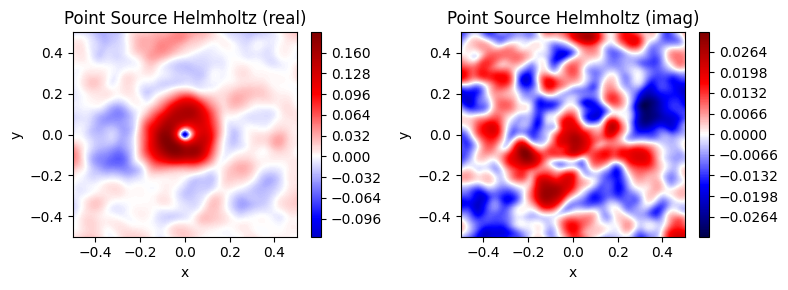

In [10]:
model_pred(model, Lx/2, Ly/2)

In [55]:
def plot_cut(model):
    x, y = torch.linspace(0, 0.5, 100), torch.zeros(100)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)

    import scipy
    xx = np.linspace(0, 0.5, 100)
    hankel = scipy.special.hankel2(0, 20 * xx) * 0.25j
    plt.plot(x.detach().numpy(), (p[:, 0:1]).detach().numpy(), xx, hankel.real)

/tmp/ipykernel_28292/222225716.py:9: RuntimeWarning: invalid value encountered in multiply
  hankel = scipy.special.hankel2(0, 20 * xx) * 0.25j


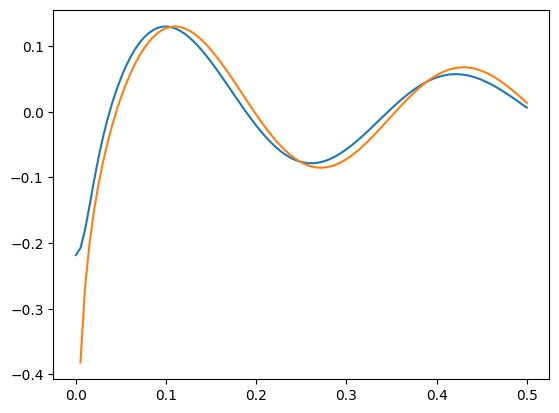

In [56]:
plot_cut(model.to('cpu'))